In [8]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import pickle

%matplotlib qt

In [9]:
def undistort_fn():
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        # store all corners and object point in these two lists
    corner_pts = []
    object_pts = []

    # read the directory of chessboard images
    images = glob.glob('./camera_calibration/*.jpg')

    for index, file_name in enumerate(images):
        img = cv2.imread(file_name)
        gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

        # find corners in the gray scale img
        ret, corners = cv2.findChessboardCorners(gray, (9,6) , None)

        if ret == True:
            corner_pts.append(corners)
            object_pts.append(obj_pts)

            img = cv2.drawChessboardCorners(img , (7,6) , corners,ret)
          #  cv2.imshow('img' , img)
           # cv2.waitKey(500)

    #cv2.destroyAllWindows()
    gray_zise = (img.shape[1] , img.shape[0])        

    #This method returns the camera matrix, distortion coefficients, rotation and translation vectors etc.
    ret , mtx , dist , rvecs , tvecs = cv2.calibrateCamera(object_pts , corner_pts , gray_zise,None,None)

    # undistort the image

    undistort_img = cv2.undistort(img,mtx,dist ,None ,mtx)

    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('camera_calibration/calibration_picke.p', 'wb'))

In [10]:
def undistort_images(img , calibration_dir = './camera_calibration/calibration_picke.p'):
    
    with open(calibration_dir , mode='rb') as f:
        file = pickle.load(f)
        mtx = file['mtx']
        dist = file['dist']
        
        undistort_img = cv2.undistort(img,mtx,dist,None,mtx)
        
        return undistort_img

In [11]:
def complete_pipeline_hls(img ,s_gradient_thresh = (15,255), s_channel_thresh = (100,255)):
    img = undistort_images(img)
    
    # copy of image
    img_copy = np.copy(img)
    
    # calculate hls color scheme
    hls = cv2.cvtColor(img_copy , cv2.COLOR_RGB2HLS).astype(np.float)
    h_hls = hls[:,:,0]
    l_hls = hls[:,:,1]
    s_hls = hls[:,:,2]
    
    # find edges
    x_sobel = cv2.Sobel(l_hls , cv2.CV_64F , 1,1)
    
    abs_sobel = np.absolute(x_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    gradient_binary = np.zeros_like(scaled_sobel)
    gradient_binary[(scaled_sobel >= s_gradient_thresh[0]) & (scaled_sobel <= s_gradient_thresh[1])]   
    
    # Threshold color channel
    channel_binary = np.zeros_like(s_hls)
    channel_binary[(s_hls >= s_channel_thresh[0]) & (s_hls <= s_channel_thresh[1])] = 1
    
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(channel_binary == 1) | (gradient_binary == 1)] = 1
        
    return combined_binary
    

In [12]:
def complete_pipeline_hsv(img ,s_gradient_thresh = (15,255), s_channel_thresh = (100,255)):
    img = undistort_images(img)
    
    # copy of image
    img_copy = np.copy(img)
    
     # calculate hsv color scheme
    hsv = cv2.cvtColor(img_copy , cv2.COLOR_RGB2HSV)
    h_hsv = hsv[:,:,0]
    s_hsv = hsv[:,:,1]
    v_hsv = hsv[:,:,2]
    
    
    x_sobel = cv2.Sobel(v_hsv , cv2.CV_64F , 1, 1)
    
    abs_sobel = np.absolute(x_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold Binary
    gradient_binary = np.zeros_like(scaled_sobel)
    gradient_binary[(scaled_sobel >= s_gradient_thresh[0]) & (scaled_sobel <= s_gradient_thresh[1])] 
    
    # Threshold color Channel
    channel_binary = np.zeros_like(s_hsv)
    channel_binary[(s_hsv >= s_channel_thresh[0]) & (s_hsv <= s_channel_thresh[1])] = 1
    
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(channel_binary == 1) | (gradient_binary == 1)] = 1
    
    return combined_binary

NameError: name 'img' is not defined

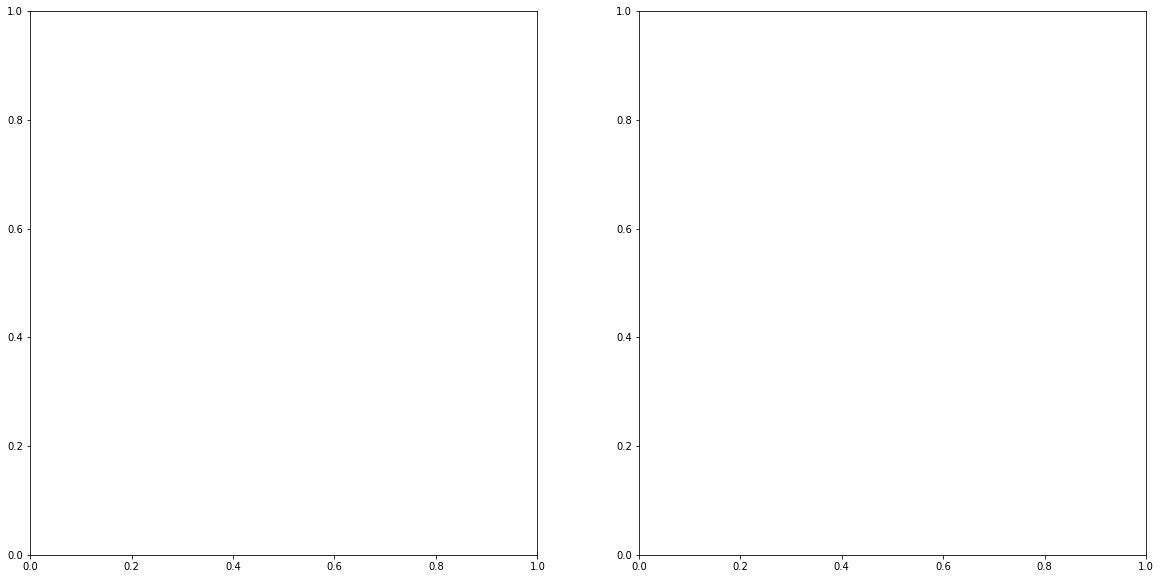

In [6]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_img)
ax2.set_title('Undistorted Image', fontsize=30)

In [13]:
# to get birds eye view

# create a transoform matrix
def perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    
    img_size = np.float32([(img.shape[1],img.shape[0])]) 
    src = src *img_size
    
    dst = dst*np.float32(dst_size)
    
    M = cv2.getPerspectiveTransform(src , dst)
    
    warped = cv2.warpPerspective(img ,M, dst_size)
    
    return warped

In [14]:
def inv_perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    
    img_size = np.float32([(img.shape[1],img.shape[0])]) 
    src = src *img_size
    
    dst = dst*np.float32(dst_size)
    
    M = cv2.getPerspectiveTransform(src , dst)
    
    warped = cv2.warpPerspective(img ,M, dst_size)
    
    return warped

In [15]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:] , axis = 0)
    return hist

## Sliding Window

In [16]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

In [17]:
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = complete_pipeline_hls(img)
dst = perspective_warp(dst, dst_size=(1280,720))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

Text(0.5,1,'Warped Image')

In [20]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(dst)
#plt.imshow(out_img)
#plt.plot(curves[0], ploty, color='yellow', linewidth=1)
#plt.plot(curves[1], ploty, color='yellow', linewidth=1)
print(np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
print(curverad)
img_ = draw_lanes(img, curves[0], curves[1])
plt.imshow(img_, cmap='hsv')

(2, 720)
(3127.943512037567, 1024.8875477153783, 0.254459328415389)


In [21]:
f, (ax1, ax2, ax3, ax4 , ax5) = plt.subplots(1, 5, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=100)
ax2.imshow(dst)
ax2.set_title('Filter+Perspective Tform', fontsize=100)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100)
ax4.imshow(img_)

ax4.set_title('Overlay Lanes', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [22]:
def vid_pipeline(img):
    global running_avg
    global index
    img_ = pipeline(img)
    img_ = perspective_warp(img_)
    out_img, curves, lanes, ploty = sliding_window(img_, draw_windows=False)
    curverad =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    return img

In [ ]:
right_curves, left_curves = [],[]
#from moviepy.editor import VideoFileClip

myclip = cv2.Vid
#myclip = VideoFileClip('project_video.mp4')#.subclip(40,43)
output_vid = 'output.mp4'
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)

